<a href="https://colab.research.google.com/github/nayrr25/BayesianMMM/blob/main/Modelo_Prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entorno


In [9]:
!apt-get install -y build-essential
!pip install cmdstanpy==1.2.3 pandas numpy matplotlib pyyaml
!git clone https://github.com/leopoldavezac/BayesianMMM.git
%cd BayesianMMM
!pip install -e .



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.2.5
    Uninstalling cmdstanpy-1.2.5:
      Successfully uninstalled cmdstanpy-1.2.5
Cloning into 'BayesianMMM'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 300 (delta 131), reused 275 (delta 119), pack-reused 0 (from 0)
Receiving objects: 100% (300/300), 2.59 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/BayesianMMM/BayesianMMM/BayesianMMM
Obtaining file:///content/BayesianMMM/BayesianMMM/BayesianMMM
  Preparing metadata (setup.py) ... done
  Attempting uninstall: bayesian_mmm

In [10]:
from cmdstanpy import install_cmdstan
install_cmdstan()


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpb5fwjg31
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.37.0
Test model compilation


True

# Ejecuta el modelo Bayessiano

In [49]:
import pandas as pd
import numpy as np
import yaml
import pymc as pm
import arviz as az

# -------------------------------------------------
# 1. Cargar config YAML
# -------------------------------------------------
config_yaml = """
DATA_SOURCE_PATH: "./data/mmm.csv"
EXPERIMENT_NM: "demo"
MEDIA_NMS:
  - TV
  - radio
  - newspaper
CTRL_NMS: []
DATE_NM: "week_dt"
TARGET_NM: "sales"
NORMALIZATION:
  PREDICTORS:
    transfo_nm: null
    scaler_nm: "max_abs"
  TARGET:
    transfo_nm: null
    scaler_nm: "max_abs"
MAX_LAG: 13
CARRYOVER_TRANSFO_NM: "adstock"
DIMINUSHING_RETURNS_TRANSFO_NM: "reach"
SAMPLING_N_ITER: 2000
SAMPLING_N_PROCESSORS: 3
PARAMETER_ESTIMATOR_NM: "median"
NB_TEST_OBS: 20
"""

cfg = yaml.safe_load(config_yaml)

data_path = cfg["DATA_SOURCE_PATH"]
media_cols = cfg["MEDIA_NMS"]
ctrl_cols = cfg["CTRL_NMS"]
date_col = cfg["DATE_NM"]
y_col = cfg["TARGET_NM"]
n_test = cfg["NB_TEST_OBS"]

max_lag = cfg["MAX_LAG"]

# -------------------------------------------------
# 2. Leer datos
# -------------------------------------------------
df = pd.read_csv(data_path)

# ordenar por fecha por si acaso
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

# -------------------------------------------------
# 3. Funciones de transformación
# -------------------------------------------------
def adstock_transform(x, decay=0.5, max_lag=13):
    """
    Aplica adstock con decaimiento geométrico.
    Retorna una serie del mismo largo que x.
    """
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    for t in range(len(x)):
        carry = 0.0
        for lag in range(max_lag + 1):
            if t - lag >= 0:
                carry += (decay ** lag) * x[t - lag]
        out[t] = carry
    return out

def saturation_transform(x, alpha=1.5, theta=None):
    """
    Rendimientos decrecientes tipo Hill.
    sat(x) = x^alpha / (x^alpha + theta^alpha)
    """
    x = np.asarray(x, dtype=float)
    if theta is None:
        theta = 0.5 * np.max(x) if np.max(x) > 0 else 1.0
    num = np.power(x, alpha)
    den = num + np.power(theta, alpha)
    return num / den

def max_abs_scale(series):
    m = np.max(np.abs(series))
    if m == 0:
        return series * 0, 1.0
    return series / m, m

# -------------------------------------------------
# 4. Construir features: adstock + saturación
# -------------------------------------------------
X_list = []
X_meta = {}  # guardo escalas para luego invertir

for col in media_cols:
    # 4.1 adstock
    ad = adstock_transform(df[col].values, decay=0.5, max_lag=max_lag)

    # 4.2 saturación
    sat = saturation_transform(ad, alpha=1.5, theta=0.5 * np.max(ad) if np.max(ad) > 0 else 1.0)

    # 4.3 escalar con max_abs (como dice config)
    sat_scaled, scale_val = max_abs_scale(sat)

    X_list.append(sat_scaled)
    X_meta[col] = {
        "adstock": ad,
        "sat": sat,
        "scale_val": scale_val
    }

# Variables de control si existieran
for col in ctrl_cols:
    ctrl_scaled, ctrl_scale_val = max_abs_scale(df[col].values)
    X_list.append(ctrl_scaled)
    X_meta[col] = {
        "adstock": None,
        "sat": None,
        "scale_val": ctrl_scale_val
    }

# Matriz final de predictores
X = np.vstack(X_list).T  # shape (n_obs, n_features)
feature_names = media_cols + ctrl_cols

# 4.4 Escalar el target con max_abs
y_scaled, y_scale_val = max_abs_scale(df[y_col].values)

# -------------------------------------------------
# 5. Train / Test split
# -------------------------------------------------
n_total = df.shape[0]
n_train = n_total - n_test

X_train = X[:n_train]
X_test  = X[n_train:]

y_train = y_scaled[:n_train]
y_test  = y_scaled[n_train:]

# -------------------------------------------------
# 6. Modelo Bayesiano
# -------------------------------------------------
with pm.Model() as mmm_model:
    # Priors para coeficientes de cada medio
    betas = pm.HalfNormal("betas", sigma=1.0, shape=X_train.shape[1])
    # Intercept
    intercept = pm.Normal("intercept", mu=0.0, sigma=1.0)
    # Ruido
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu = intercept + pm.math.dot(X_train, betas)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(
        draws=cfg["SAMPLING_N_ITER"],
        chains=cfg["SAMPLING_N_PROCESSORS"],
        target_accept=0.9,
        progressbar=False
    )

# -------------------------------------------------
# 7. Resumen posterior
# -------------------------------------------------
summary = az.summary(trace, var_names=["intercept", "betas", "sigma"], hdi_prob=0.9)

# Estimador puntual (mediana, según config)
beta_median = np.median(trace.posterior["betas"].values, axis=(0,1))
intercept_median = np.median(trace.posterior["intercept"].values)
sigma_median = np.median(trace.posterior["sigma"].values)

# -------------------------------------------------
# 8. Predicciones in-sample / test
# -------------------------------------------------
def predict_from_params(Xmat, betas_point, intercept_point):
    return intercept_point + Xmat @ betas_point

yhat_train_scaled = predict_from_params(X_train, beta_median, intercept_median)
yhat_test_scaled  = predict_from_params(X_test , beta_median, intercept_median)


In [50]:
# -------------------------------------------------
# 8. Predicciones in-sample / test
# -------------------------------------------------
def predict_from_params(Xmat, betas_point, intercept_point):
    """Predice valores escalados a partir de los parámetros estimados"""
    return intercept_point + Xmat @ betas_point

yhat_train_scaled = predict_from_params(X_train, beta_median, intercept_median)
yhat_test_scaled  = predict_from_params(X_test , beta_median, intercept_median)

# Desescalar para volver a unidades reales de ventas
yhat_train = yhat_train_scaled * y_scale_val
yhat_test  = yhat_test_scaled  * y_scale_val
y_train_real = y_train * y_scale_val
y_test_real  = y_test  * y_scale_val

# -------------------------------------------------
# 9. Contribución por canal
# -------------------------------------------------
channel_contrib_scaled = {}
channel_contrib_real = {}

for i, ch in enumerate(feature_names):
    contrib_scaled = beta_median[i] * X[:, i]
    channel_contrib_scaled[ch] = contrib_scaled
    channel_contrib_real[ch] = contrib_scaled * y_scale_val

avg_contrib_real_train = {
    ch: channel_contrib_real[ch][:n_train].mean() for ch in feature_names
}

total_pred_train = yhat_train.mean()
channel_share = {
    ch: avg_contrib_real_train[ch] / total_pred_train if total_pred_train != 0 else np.nan
    for ch in feature_names
}

# -------------------------------------------------
# 10. ROI aproximado
# -------------------------------------------------
roi = {}
for ch in media_cols:
    spend_mean = df[ch].iloc[:n_train].mean()
    incr_mean = avg_contrib_real_train[ch]
    roi[ch] = incr_mean / spend_mean if spend_mean != 0 else np.nan

# -------------------------------------------------
# 11. Resultados y métricas
# -------------------------------------------------
print("=== MMM BAYESIAN RESULTS ===")
print("\nCoeficientes (mediana posterior):")
for i, ch in enumerate(feature_names):
    print(f"  {ch}: {beta_median[i]:.4f}")

print(f"\nIntercept: {intercept_median:.4f}")
print(f"Sigma (ruido): {sigma_median:.4f}")

# Performance Train/Test
mape_train = np.mean(np.abs((y_train_real - yhat_train) / y_train_real)) * 100
rmse_train = np.sqrt(np.mean((y_train_real - yhat_train) ** 2))
mape_test = np.mean(np.abs((y_test_real - yhat_test) / y_test_real)) * 100
rmse_test = np.sqrt(np.mean((y_test_real - yhat_test) ** 2))

print("\n--- Performance ---")
print(f"MAPE Train: {mape_train:.2f}%   RMSE Train: {rmse_train:.2f}")
print(f"MAPE Test : {mape_test:.2f}%   RMSE Test : {rmse_test:.2f}")

# Contribución
print("\n--- Contribución promedio (Train) ---")
for ch, val in avg_contrib_real_train.items():
    print(f"{ch}: {val:.2f}")

# Participación
print("\n--- Participación en ventas modeladas ---")
for ch, share in channel_share.items():
    print(f"{ch}: {share*100:.1f}%")

# ROI
print("\n--- ROI estimado por canal ---")
for ch, r in roi.items():
    print(f"{ch}: {r:.3f}")

print("\n--- Resumen Bayesiano (HDI 90%) ---")
print(az.summary(trace, var_names=['intercept', 'betas', 'sigma'], hdi_prob=0.9))


=== MMM BAYESIAN RESULTS ===

Coeficientes (mediana posterior):
  TV: 0.7363
  radio: 0.4298
  newspaper: 0.0197

Intercept: -0.3104
Sigma (ruido): 0.1114

--- Performance ---
MAPE Train: 21.36%   RMSE Train: 2.96
MAPE Test : 23.52%   RMSE Test : 3.71

--- Contribución promedio (Train) ---
TV: 13.73
radio: 8.30
newspaper: 0.29

--- Participación en ventas modeladas ---
TV: 98.5%
radio: 59.6%
newspaper: 2.1%

--- ROI estimado por canal ---
TV: 0.094
radio: 0.350
newspaper: 0.009

--- Resumen Bayesiano (HDI 90%) ---
            mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.311  0.047  -0.392   -0.238      0.001    0.001    2426.0   
betas[0]   0.737  0.047   0.657    0.812      0.001    0.001    2803.0   
betas[1]   0.431  0.045   0.360    0.507      0.001    0.001    3246.0   
betas[2]   0.025  0.022   0.000    0.055      0.000    0.000    3587.0   
sigma      0.112  0.006   0.101    0.121      0.000    0.000    3845.0   

           ess_tail  r_hat  
interc

🧩 Paso 1 — Cargar tus coeficientes del modelo

Después de correr tu script anterior, ya tienes estos valores:

In [51]:
beta_median   # array con coeficientes por canal
intercept_median
y_scale_val   # escala del target
X_meta        # contiene las escalas de cada medio


{'TV': {'adstock': array([230.1       , 159.55      ,  96.975     , 199.9875    ,
         280.79375   , 149.096875  , 132.0484375 , 186.22421875,
         101.71210937, 250.65605469, 191.42802734, 310.41401367,
         179.00700684, 187.00350342, 297.58770752, 344.1911377 ,
         239.89451904, 401.3380127 , 269.85797119, 282.22845459,
         359.51071777, 417.14802246, 221.77348633, 339.17454834,
         231.88323975, 378.82851562, 332.31280518, 406.25045166,
         451.91276855, 296.54445801, 441.16809082, 333.46687012,
         263.92921143, 397.55561523, 294.46447754, 437.91774902,
         485.85806885, 317.6151001 , 201.90374756, 328.93582764,
         366.95919189, 360.46494141, 473.81728516, 443.8043335 ,
         246.98428955, 298.58525391, 238.98669434, 359.37713623,
         406.88272705, 270.32362061, 334.94552002, 267.86820068,
         350.33146973, 357.75181885, 441.5635498 , 419.67097168,
         217.11756592, 244.74615479, 333.17154541, 377.27508545,
        

🧪 Paso 2 — Crear una función de simulación

Agrega este bloque después del modelo, o incluso en un nuevo script simulate_mmm.py:

In [52]:
def simulate_sales(scenario_dict, betas, intercept, y_scale_val, meta_dict, alpha=1.5):
    """
    Simula ventas esperadas dado un nuevo escenario de inversión por canal.
    scenario_dict = {'TV': 1.1, 'radio': 0.9, 'newspaper': 1.0}
    significa: TV +10%, radio -10%, newspaper igual.
    """
    contrib_total = 0
    for i, ch in enumerate(media_cols):
        # Recuperar inversión original y escala
        orig_adstock = meta_dict[ch]['adstock']
        max_val = np.max(orig_adstock)
        if max_val == 0:
            continue

        # Escalar según multiplicador
        new_spend = orig_adstock * scenario_dict.get(ch, 1.0)

        # Aplicar saturación (rendimientos decrecientes)
        theta = 0.5 * max_val
        sat = np.power(new_spend, alpha) / (np.power(new_spend, alpha) + np.power(theta, alpha))

        # Calcular contribución con el beta estimado
        contrib_total += betas[i] * sat

    # Agregar intercepto
    yhat_scaled = intercept + contrib_total
    yhat_real = yhat_scaled * y_scale_val
    return np.mean(yhat_real)


📊 Paso 3 — Definir escenarios y compararlos

Ejemplo práctico:

In [54]:
# Escenario base (sin cambios)
base_sales = simulate_sales({'TV':1, 'radio':1, 'newspaper':1},
                            beta_median, intercept_median, y_scale_val, X_meta)

# Escenario A: +10% TV, -10% radio
scenario_A_sales = simulate_sales({'TV':1.1, 'radio':0.9, 'newspaper':1},
                                  beta_median, intercept_median, y_scale_val, X_meta)

# Escenario B: +20% radio, -10% newspaper
scenario_B_sales = simulate_sales({'TV':1, 'radio':1.2, 'newspaper':0.9},
                                  beta_median, intercept_median, y_scale_val, X_meta)

print(f"Ventas base estimadas: {base_sales:,.0f}")
print(f"Escenario A (+10% TV, -10% radio): {scenario_A_sales:,.0f} ({(scenario_A_sales/base_sales - 1)*100:.2f}% cambio)")
print(f"Escenario B (+20% radio, -10% newspaper): {scenario_B_sales:,.0f} ({(scenario_B_sales/base_sales - 1)*100:.2f}% cambio)")


Ventas base estimadas: 8
Escenario A (+10% TV, -10% radio): 8 (2.93% cambio)
Escenario B (+20% radio, -10% newspaper): 9 (8.71% cambio)


🧮 Paso 4 — Hacer un simulador de presupuesto total

Si quieres probar diferentes combinaciones manteniendo un presupuesto total constante, puedes hacer algo así:

In [55]:
import itertools

def simulate_budget_allocation(betas, intercept, y_scale_val, meta_dict, budget_total=1.0, step=0.1):
    """
    Simula todas las combinaciones posibles de asignación de presupuesto
    entre canales, dado un total fijo.
    """
    allocations = np.arange(0, 1.0 + step, step)
    combos = [(a, b, 1 - a - b) for a in allocations for b in allocations if a + b <= 1]
    results = []
    for tv, radio, newspaper in combos:
        scenario = {'TV': tv*budget_total*3, 'radio': radio*budget_total*3, 'newspaper': newspaper*budget_total*3}
        sales = simulate_sales(scenario, betas, intercept, y_scale_val, meta_dict)
        results.append({'TV_share': tv, 'radio_share': radio, 'newspaper_share': newspaper, 'sales': sales})
    return pd.DataFrame(results)


In [56]:
df_sim = simulate_budget_allocation(beta_median, intercept_median, y_scale_val, X_meta)
best = df_sim.loc[df_sim['sales'].idxmax()]
print("💡 Mejor distribución de presupuesto encontrada:")
print(best)


💡 Mejor distribución de presupuesto encontrada:
TV_share            0.500000
radio_share         0.500000
newspaper_share     0.000000
sales              12.066591
Name: 50, dtype: float64


/tmp/ipython-input-2136330518.py:20: RuntimeWarning: invalid value encountered in power
  sat = np.power(new_spend, alpha) / (np.power(new_spend, alpha) + np.power(theta, alpha))


📈 Paso 5 — Visualizar los escenarios

Puedes graficar los resultados de simulación:

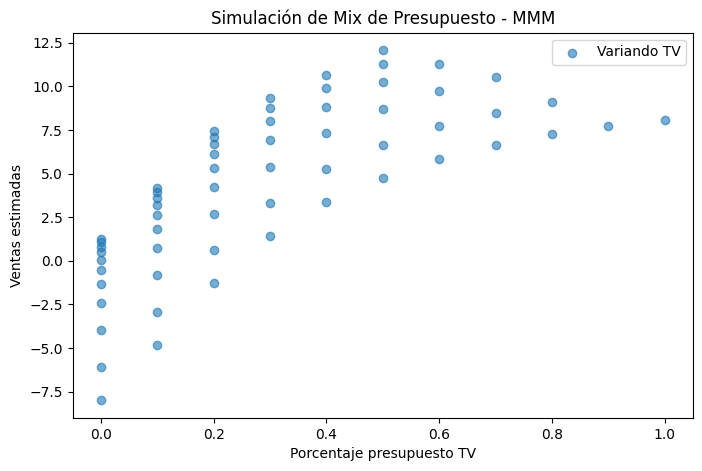

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df_sim['TV_share'], df_sim['sales'], label='Variando TV', alpha=0.6)
plt.xlabel('Porcentaje presupuesto TV')
plt.ylabel('Ventas estimadas')
plt.title('Simulación de Mix de Presupuesto - MMM')
plt.legend()
plt.show()
